In [11]:
import os
import random

import numpy as np
import pandas as pd
import scipy.io
import scipy.spatial

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

**Model Building and Training**

*Source Approximation*

One model used for source approximation: a Long Short Term Memory Model (LSTM). This LSTM is separate from the one used in the trajectory prediction.

*Trajectory Predication*

Two models used for trajectory prediction: a Long Short Term Memory Model(LSTM) and a Hidden Markov Model(HMM).

The LSTM was built using the PyTorch library and the HMM is a custom built model.

In [23]:
def euclidean_distance_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=1) + 1e-6))

SOURCE APPROXIMATION

In [ ]:
# Building and training the LSTM

def generate_random_points(x0, y0, z0):
    x = [0, 0, 0]
    y = [0, 0, 0]
    z = [0, 0, 0]

    for i in range(3):
        x[i] = x0 + np.random.uniform(0,1)
    for i in range(3):
        y[i] = y0 + np.random.uniform(0,1)
    for i in range(3):
        z[i] = z0 + np.random.uniform(0.01,0.1)

    return [[x[0], y[0], z[0]], [x[1], y[1], z[1]], [x[2], y[2], z[2]]]

# Function to generate synthetic data
def generate_data(num_samples=50000):
    X_train, Y_train = [], []

    for _ in range(num_samples):
        x0, y0, z0 = np.random.randint(0, 50, 3)  # Source location

        # Generate 3 observation points
        points = generate_random_points(x0, y0, z0)
        concentrations = []

        for x, y, z in points:

            # Constants
            x_factor = 2
            u = 1  # Wind speed
            H = 0
            ay, by = 1, 0.92
            az, bz = 1, 0.87

            # Calculate s_y and s_z
            s_y = 1 * ay * abs(x - x0) ** by
            s_z = 1 * az * abs(x - x0) ** bz

            # Take care of divide by zero by checking s_y and s_z
            if s_y == 0:
                s_y = 0.0002
            if s_z == 0:
                s_z = 0.0002

            # Calculate the exponential terms
            EXP1 = -(y - y0) ** 2 / (s_y ** 2)
            EXP2 = -(z - z0 - H) ** 2 / (2 * s_z ** 2)
            EXP3 = -(z - z0 + H) ** 2 / (2 * s_z ** 2)

            # Calculate concentration
            concentration = 100 * 1 / (2 * np.pi * s_y * s_z * u)

            # Check if x is less than x0 (if so, concentration becomes 0)
            if x < x0:
                concentration = 0

            # Calculate concentration based on the exponential terms
            concentration *= np.exp(EXP1)
            concentration *= np.exp(EXP2) + np.exp(EXP3)

            # Max concentration to 300
            if concentration > 300:
                concentration = 300


            concentrations.append(concentration)

        input_features = np.column_stack((points, concentrations))
        X_train.append(input_features)
        Y_train.append([x0, y0, z0])
    return np.array(X_train), np.array(Y_train)

# Generate data using the Gaussian Plume Equation and split data
X, Y = generate_data()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

source = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(3, 4)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(3)
])

# compile model using adam optimizer and euclidean distance as a loss function
source.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=euclidean_distance_loss)

# Train the model
history = source.fit(X_train, Y_train, epochs=51, batch_size=64, validation_data=(X_val, Y_val), verbose=1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (Euclidean Distance)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

source.save('pre-trained_models/trajectory_model.keras')

Epoch 1/51


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 38.6383 - val_loss: 21.1577
Epoch 2/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.5762 - val_loss: 7.6242
Epoch 3/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3896 - val_loss: 1.6567
Epoch 4/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2883 - val_loss: 0.7065
Epoch 5/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6390 - val_loss: 0.4960
Epoch 6/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4477 - val_loss: 0.3881
Epoch 7/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3680 - val_loss: 0.3275
Epoch 8/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3221 - val_loss: 0.2970
Epoch 9/51
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2895 - val_loss: 0.2654
Epoch 10/51
 69/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2732

KeyboardInterrupt: 

Or insert previously trained model

In [ ]:
source = load_model('models/trajectory_model.keras', custom_objects={'euclidean_distance_loss': euclidean_distance_loss}) # replace with location of file

TRAJECTORY PREDICTION

In [20]:
# Building HMM

class HMM3DWithViterbi:
    def __init__(self, n_states, nn_hidden_layers=50, max_iter=1000):
        self.n_states = n_states

        # uniform transition probabilities
        self.transition_matrix = np.ones((n_states, n_states)) / n_states

        # Uniform initial probabilities
        self.initial_probs = np.ones(n_states) / n_states

        #MLPRegressor used for non-linear emmission probabilities
        self.nn_models = [MLPRegressor(hidden_layer_sizes=nn_hidden_layers, max_iter=max_iter) for _ in range(n_states)]  # One NN per state

    # implements the viterbi algorithm to find the most probable sequence of hidden states
    def viterbi(self, observations):
        # number of observations in the path
        n_observations = len(observations)
        # stores the log-probabilities of all the paths that end in hidden state j at time t
        log_probs = np.zeros((n_observations, self.n_states))
        # stores the best path
        paths = np.zeros((n_observations, self.n_states), dtype=int)

        # defining the probabilities for the first observation
        emission_probs = self._emission_probabilities(observations[0])
        log_probs[0] = np.log(self.initial_probs + 1e-9) + np.log(emission_probs + 1e-9)

        # loop to go through all possible paths and find the best one based on the emission probabilities
        for t in range(1, n_observations):
            for j in range(self.n_states):
                transition_probs = log_probs[t - 1] + np.log(self.transition_matrix[:, j] + 1e-9)
                best_prev_state = np.argmax(transition_probs)
                log_probs[t, j] = transition_probs[best_prev_state] + np.log(self._emission_probabilities(observations[t])[j] + 1e-9)
                paths[t, j] = best_prev_state

        # backtracking to give the most probable path
        best_last_state = np.argmax(log_probs[-1])
        best_path = [best_last_state]
        for t in range(n_observations - 1, 0, -1):
            best_last_state = paths[t, best_last_state]
            best_path.append(best_last_state)
        return list(reversed(best_path))

    # function to train the model
    def fit(self, all_observations):
        # preparing the data
        X_by_state = [[] for _ in range(self.n_states)]
        y_by_state = [[] for _ in range(self.n_states)]
        sum = 0
        total = 0
        all_data = np.vstack(all_observations)
        # kmeans clustering used to see how many hidden states are needed for the specific data
        kmeans = KMeans(n_clusters=self.n_states, n_init=10).fit(all_data)
        initial_states = kmeans.labels_

        # associates parts of the trajectory with certain hidden states
        for trajectory in all_observations:
            states = self.viterbi(trajectory)[:-2]
            for t, state in enumerate(states):
                X_by_state[state].append(trajectory[t])
                y_by_state[state].append(trajectory[t + 1])

        # trains the emission probabilties model using the data
        for state in range(self.n_states):
            X = np.array(X_by_state[state])
            y = np.array(y_by_state[state])
            if len(X) > 10:
                x = 10
                self.nn_models[state].fit(X, y)

            # used to find the error from what the HMM predicted
            for i, x_val in zip(y, X):
                norm_i = i / (np.linalg.norm(i) + 1e-9)
                norm_point = self.predict(x_val) / (np.linalg.norm(self.predict(x_val)) + 1e-9)
                sum += scipy.spatial.distance.euclidean(norm_i, norm_point)
                total += 1
            print(total)
            print("training loss: ", sum/total)

        # updates starting transission matrix with the information learned from the training (used ot update the transimission matrix from being uniform to something that can accurately represent the data)
        for i in range(len(states) - 1):
            self.transition_matrix[states[i], states[i + 1]] += 1
        self.transition_matrix /= self.transition_matrix.sum(axis=1, keepdims=True)

    # predict function
    def predict(self, observations):
        if observations.ndim == 1:
            observations = [observations]
        hidden_states = self.viterbi(observations)
        last_hidden_state = hidden_states[-1]
        return self.nn_models[last_hidden_state].predict([observations[-1]])[-1]

    # defining the emission probabilities
    def _emission_probabilities(self, observation):
        emissions = []
        for state in range(self.n_states):
            try:
                predicted = self.nn_models[state].predict([observation])
                likelihood = np.exp(-np.linalg.norm(predicted - observation))
            except Exception:
                likelihood = 1e-6
            emissions.append(likelihood)
        emissions = np.array(emissions)
        return emissions / emissions.sum()

In [21]:
# Building LSTM
import torch
import torch.nn as nn
import torch.optim as optim

# outline of the LSTM class used
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=5, output_size=3):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        output = self.fc(out[:, :, :])
        return output

preparing data for training

In [18]:
import os
import pandas as pd
import numpy as np

# converting csv data to tensor
all_observations = []

# replace with folder for the train
dataset_folder = "train_data"
datasets_list = os.listdir(dataset_folder)
raw_data = []
for dt in datasets_list:
  x = input()
  print(dt)
  raw_data = pd.read_csv(os.path.join(dataset_folder, dt), delimiter=",",
                               names=["frame", "ped", "x", "y", "z"], usecols=[0, 1, 2, 3, 4], na_values="?")
  raw_data.sort_values(by=['frame', 'ped'], inplace=True)

  ped_ids = raw_data.ped.unique()
  for p in ped_ids:
      all_observations.append(raw_data[raw_data.ped == p][["x", "y", "z"]].values)


trainingData.csv


Training the trajectory prediction models

In [46]:
def euclidean_distance_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=None)))

1568000
training loss:  0.19729335024502911
1568000
training loss:  0.19729335024502911
1568000
training loss:  0.19729335024502911
1568000
training loss:  0.19729335024502911
[6.20355  7.855458 8.056208]
[6.09247914 7.67878421 7.89713917]
1
1568000
training loss:  0.19819535900914487
1568000
training loss:  0.19819535900914487
1568000
training loss:  0.19819535900914487
1568000
training loss:  0.19819535900914487
[9.190781  2.6888013 2.5811813]
[9.03721656 2.62735332 2.55261956]
2
1568000
training loss:  0.19786729759872396
1568000
training loss:  0.19786729759872396
1568000
training loss:  0.19786729759872396
1568000
training loss:  0.19786729759872396
[8.379524  7.8397098 2.4836857]
[8.24334576 7.81670137 2.55960022]
3
[<tf.Tensor: shape=(), dtype=float32, numpy=0.26239854097366333>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16785010695457458>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15759705007076263>]


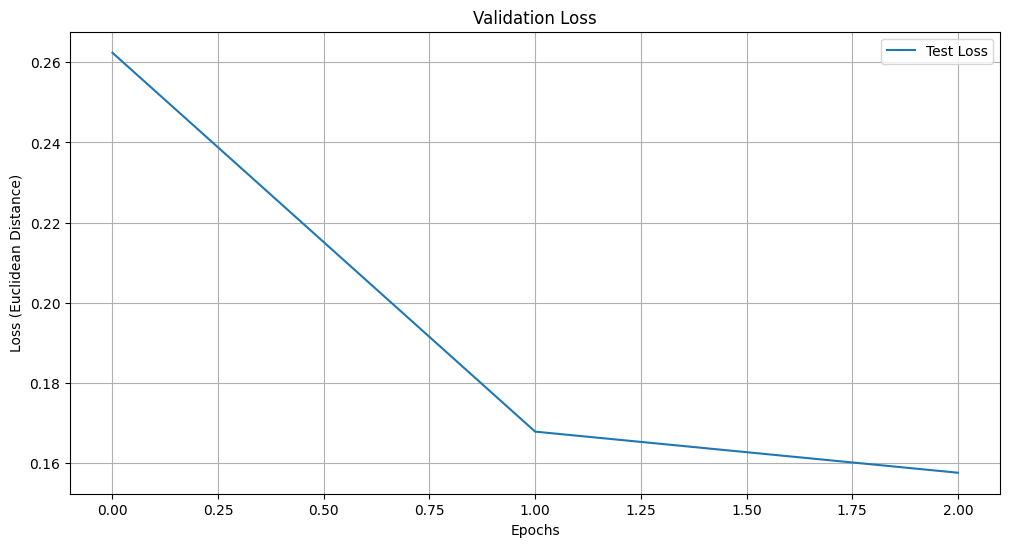

In [49]:
# HMM
# splitting data into train and test (80/20)
random.shuffle(all_observations)
n = len(all_observations)
end = int(n*0.8)
train_data = all_observations[:end]
test_data = all_observations[end:]

# defining model and training it
HMM = HMM3DWithViterbi(n_states=4)
max_epochs = 3
cur_epoch = 0
loss = []
while(cur_epoch<max_epochs):
  HMM.fit(train_data)
  traj = random.randint(0, len(test_data)-1)
  print(test_data[traj][-1])
  print(HMM.predict(test_data[traj]))
  loss.append(euclidean_distance_loss(tf.convert_to_tensor(test_data[traj][-1], dtype=tf.float32), tf.convert_to_tensor(HMM.predict(test_data[traj]), dtype=tf.float32)))
  cur_epoch+= 1
  print(cur_epoch)

print(loss)
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (Euclidean Distance)")
plt.title("Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [51]:
import pickle
with open("pre-trained_models/hmm3d_model.pkl", 'wb') as file:
        pickle.dump(HMM, file)

Using device: cpu
Epoch 1/75: Train Loss = 1.8902
Epoch 1/75: Test Loss = 0.8849
Epoch 2/75: Train Loss = 0.6906
Epoch 2/75: Test Loss = 0.5899
Epoch 3/75: Train Loss = 0.5674
Epoch 3/75: Test Loss = 0.5255
Epoch 4/75: Train Loss = 0.4910
Epoch 4/75: Test Loss = 0.4852
Epoch 5/75: Train Loss = 0.4651
Epoch 5/75: Test Loss = 0.4407
Epoch 6/75: Train Loss = 0.4560
Epoch 6/75: Test Loss = 0.4224
Epoch 7/75: Train Loss = 0.4305
Epoch 7/75: Test Loss = 0.4166
Epoch 8/75: Train Loss = 0.4240
Epoch 8/75: Test Loss = 0.4131
Epoch 9/75: Train Loss = 0.4158
Epoch 9/75: Test Loss = 0.4169
Epoch 10/75: Train Loss = 0.4045
Epoch 10/75: Test Loss = 0.3983
Epoch 11/75: Train Loss = 0.3971
Epoch 11/75: Test Loss = 0.3993
Epoch 12/75: Train Loss = 0.3946
Epoch 12/75: Test Loss = 0.3974
Epoch 13/75: Train Loss = 0.3935
Epoch 13/75: Test Loss = 0.4099
Epoch 14/75: Train Loss = 0.3912
Epoch 14/75: Test Loss = 0.3828
Epoch 15/75: Train Loss = 0.3796
Epoch 15/75: Test Loss = 0.3898
Epoch 16/75: Train Loss =

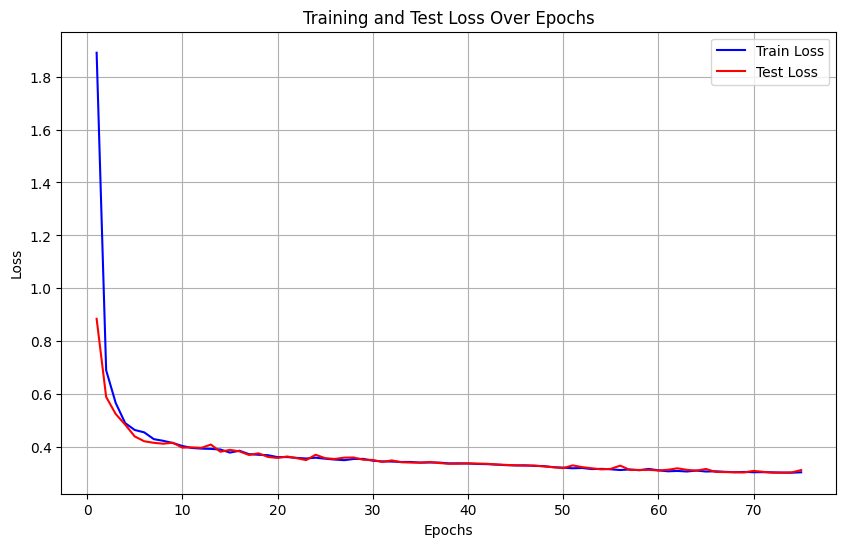

In [ ]:
# LSTM
def create_tensor_dataset(data):
    """ Convert list of numpy arrays to PyTorch tensors """
    X = [torch.tensor(traj[:-1], dtype=torch.float32) for traj in data]
    Y = [torch.tensor(traj[1:], dtype=torch.float32) for traj in data]
    return list(zip(X, Y))

# Split into training (80%) and testing (20%) datasets
random.shuffle(all_observations)
train_data, test_data = train_test_split(all_observations, test_size=0.2, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize LSTM model
lstm = LSTM(3, 128, 4, 3).to(device)

# Convert list of numpy arrays to PyTorch tensors
train_dataset = create_tensor_dataset(train_data)
test_dataset = create_tensor_dataset(test_data)

# Data loaders
batch_size = 128
tr_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Optimizer & Loss Function
optimizer = Adam(lstm.parameters(), lr=0.0001)
criterion = nn.L1Loss()

# TensorBoard Logger
log = SummaryWriter(f'logs/Ind_model')
log.add_scalar('eval/mad', 0, 0)
log.add_scalar('eval/fad', 0, 0)

# Store losses for plotting later
train_losses = []
test_losses = []

# Training Loop
max_epoch = 75  # Set number of epochs
for epoch in range(max_epoch):
  lstm.train()
  epoch_loss = 0

  # Training phase
  for X_batch, Y_batch in tr_dl:
    optimizer.zero_grad()
    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

    pred = lstm(X_batch)

    # Compute the Euclidean loss (norm of the difference)
    loss = torch.mean(torch.norm(pred - Y_batch, dim=-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=1.0)
    optimizer.step()

    epoch_loss += loss.item()

  # Average training loss
  avg_train_loss = epoch_loss / len(tr_dl)
  print(f"Epoch {epoch + 1}/{max_epoch}: Train Loss = {avg_train_loss:.4f}")

  # Append the training loss to the list
  train_losses.append(avg_train_loss)

  # Log the training loss to TensorBoard
  log.add_scalar('Loss/train', avg_train_loss, epoch + 1)

  # Testing Phase within each epoch
  lstm.eval()
  test_loss = 0

  with torch.no_grad():
    for X_batch, Y_batch in test_dl:
      X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

      # Make predictions on the test data
      pred = lstm(X_batch)

      # Compute the Euclidean loss for the test data
      loss = torch.mean(torch.norm(pred - Y_batch, dim=-1))
      test_loss += loss.item()

  # Average test loss
  avg_test_loss = test_loss / len(test_dl)
  print(f"Epoch {epoch + 1}/{max_epoch}: Test Loss = {avg_test_loss:.4f}")

  # Append the test loss to the list
  test_losses.append(avg_test_loss)

  # Log the test loss to TensorBoard
  log.add_scalar('Loss/test', avg_test_loss, epoch + 1)

# Plot the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, max_epoch + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')  # Save the plot to a file
plt.show()  # Display the plot

import torch
PATH = "pre-trained_models/trajectory_lstm.pth"
# Save the state_dict
torch.save(lstm.state_dict(), PATH)


OR insert previously trained models

In [ ]:
# bring in models
# HMM
import pickle
HMM = pickle.load(open('/content/models/hmm3d_model.pkl', 'rb')) # replace with location of files

# LSTM
import torch
lstm = LSTM(3, 128, 4, 3)
lstm.load_state_dict(torch.load('/content/models/trajectory_lstm.pth')) # replace with location of files

Build Hybrid Model

In [ ]:
ped = raw_data.ped.unique()

np.random.seed(52)
random.seed(42)

# Collect predictions from each model in a list
predictions_lstm = []
predictions_hmm = []
predictions_TF = []
outputs = []
pos = raw_data[raw_data.ped == ped[1]].to_numpy()

test = []
true = []
device = torch.device("cpu")
for p in ped:
    random_number = random.randint(1, 19)
    pos = raw_data[raw_data.ped == ped[random_number]].to_numpy()
    start = pos[0, 2:5]
    test = pos[1:, 2:5]
    his = [start]  # Initialize history with the first position

    for i in test:
        true.append(i)
        his_tensor = torch.tensor(his, dtype=torch.float32)
        his_tensor_lstm = torch.tensor([his], dtype=torch.float32)

        # Get predictions from each model
        pred_lstm = lstm(his_tensor_lstm).detach().numpy()
        pred_hmm = np.array(HMM.predict(his_tensor))

        # Append predictions to respective lists
        predictions_lstm.append(pred_lstm)
        predictions_hmm.append(pred_hmm)

        # Append new position to history
        his.append(i)
        outputs.append(i)
        break


# reshape prediction arrays to be the same size
predictions_lstm = np.array(predictions_lstm).reshape(-1, 3)
predictions_hmm = np.array(predictions_hmm).reshape(-1, 3)

# stacking the predictions by x, y, z
X_stack = np.hstack([predictions_lstm[:, 0].reshape(-1, 1), predictions_hmm[:, 0].reshape(-1, 1)])  # Shape: (num_samples, 9)
Y_stack = np.hstack([predictions_lstm[:, 1].reshape(-1, 1), predictions_hmm[:, 1].reshape(-1, 1)])
Z_stack = np.hstack([predictions_lstm[:, 2].reshape(-1, 1), predictions_hmm[:, 2].reshape(-1, 1)])

# splitting the ground truth into x, y, z
true = np.array(true)
y_true = torch.tensor(true[:, 1]).unsqueeze(1).numpy()
z_true = torch.tensor(true[:, 2]).unsqueeze(1).numpy()
x_true = torch.tensor(true[:, 0]).unsqueeze(1).numpy()

# train the respective random forest regressor (x, y, z)
meta_model_x = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model_x.fit(X_stack, x_true)

meta_model_y = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model_y.fit(Y_stack, y_true)

meta_model_z = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model_z.fit(Z_stack, z_true)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

or import previously trained hybrid models

In [ ]:
import pickle
# replace file names with new location
with open("traj_hybrid_x.pkl", "wb") as f:
    pickle.dump(meta_model_x, f)
with open("traj_hybrid_y.pkl", "wb") as f:
    pickle.dump(meta_model_y, f)
with open("traj_hybrid_z.pkl", "wb") as f:
    pickle.dump(meta_model_z, f)

Compare the trajectory models (LSTM, HMM, and Hybrid)

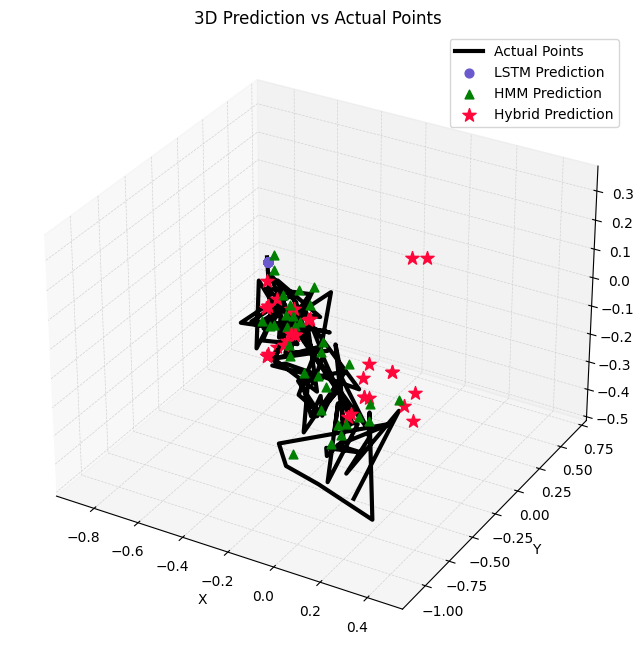


Final Error Summary:
LSTM Average 3D Error: 0.9322, Maximum 3D Error: 2.1221
HMM Average 3D Error: 0.2177, Maximum 3D Error: 0.5226
Hybrid Model Average 3D Error: 0.3950, Maximum 3D Error: 0.9579


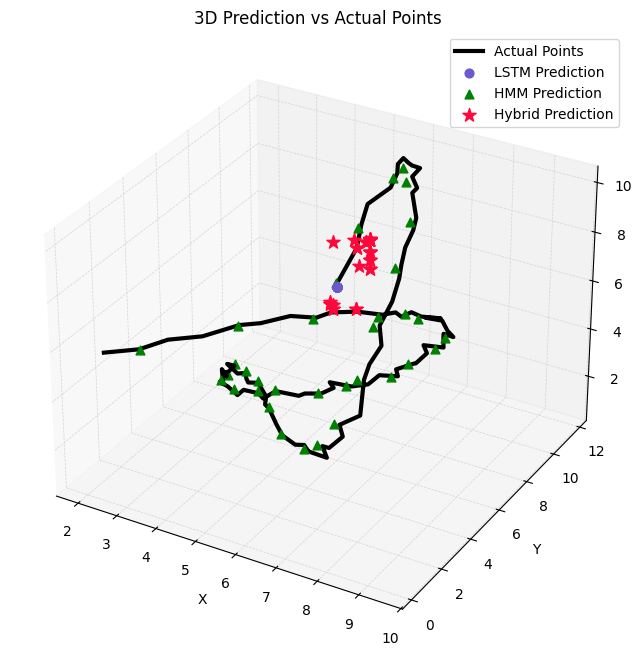


Final Error Summary:
LSTM Average 3D Error: 5.6120, Maximum 3D Error: 8.8198
HMM Average 3D Error: 0.5867, Maximum 3D Error: 1.4025
Hybrid Model Average 3D Error: 5.5840, Maximum 3D Error: 9.8244


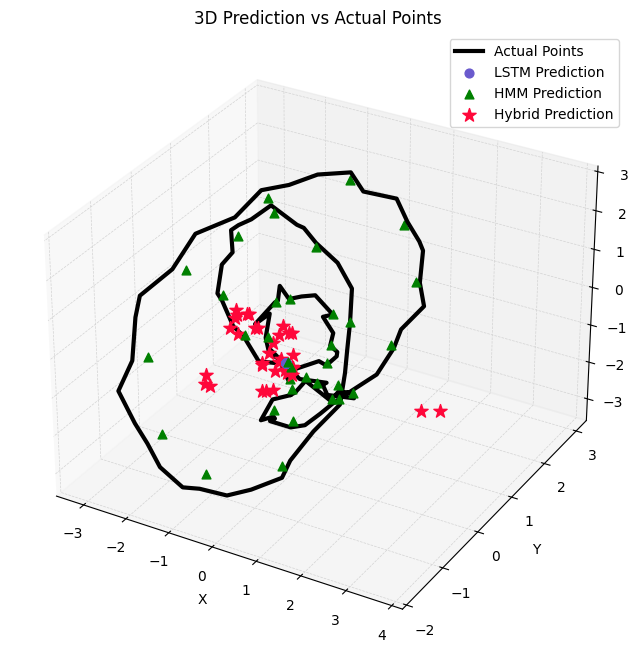


Final Error Summary:
LSTM Average 3D Error: 1.9956, Maximum 3D Error: 4.0212
HMM Average 3D Error: 0.4551, Maximum 3D Error: 0.8996
Hybrid Model Average 3D Error: 1.4922, Maximum 3D Error: 3.3438


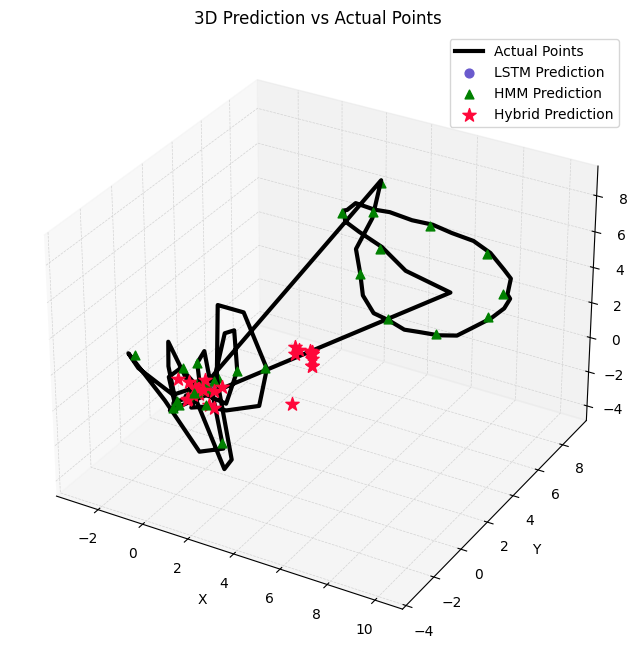


Final Error Summary:
LSTM Average 3D Error: 4.8001, Maximum 3D Error: 13.7423
HMM Average 3D Error: 1.2855, Maximum 3D Error: 14.8263
Hybrid Model Average 3D Error: 3.0231, Maximum 3D Error: 14.3298


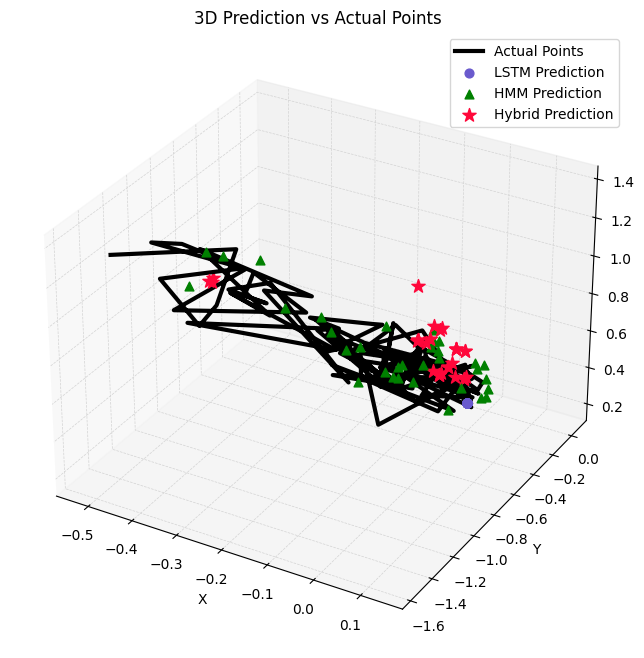


Final Error Summary:
LSTM Average 3D Error: 0.7328, Maximum 3D Error: 1.7618
HMM Average 3D Error: 0.2168, Maximum 3D Error: 0.4285
Hybrid Model Average 3D Error: 0.4430, Maximum 3D Error: 1.1773


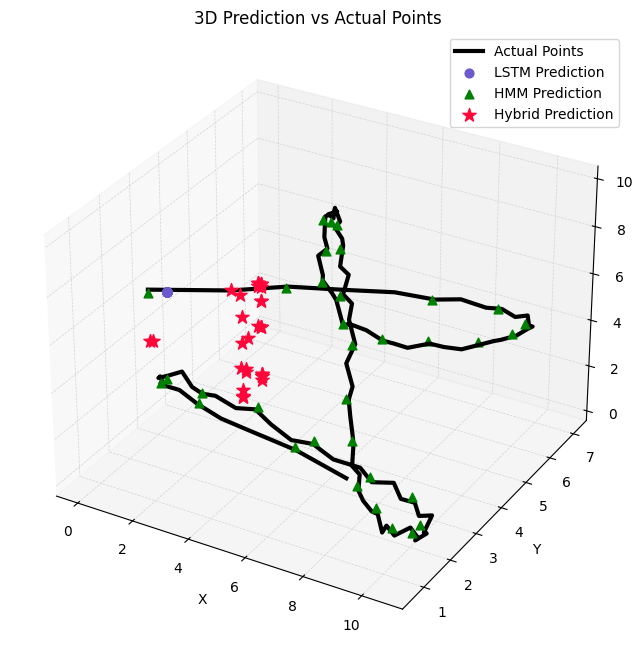


Final Error Summary:
LSTM Average 3D Error: 7.2870, Maximum 3D Error: 11.3821
HMM Average 3D Error: 0.6391, Maximum 3D Error: 2.4064
Hybrid Model Average 3D Error: 4.1582, Maximum 3D Error: 7.4960


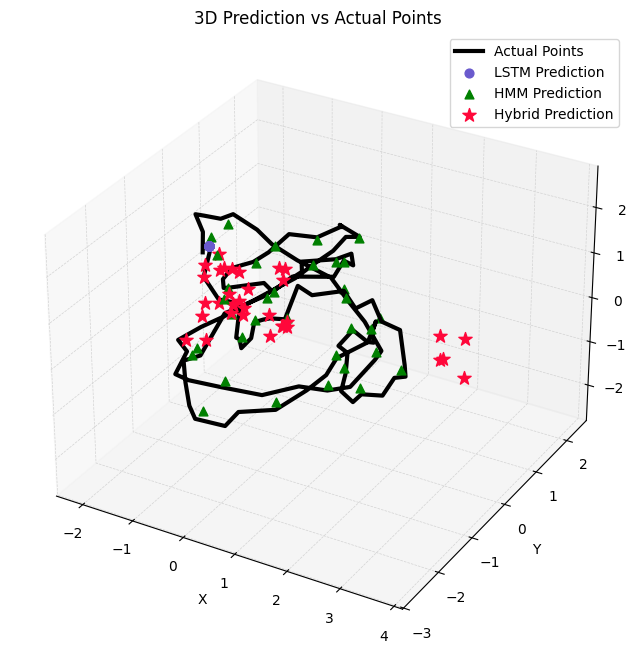


Final Error Summary:
LSTM Average 3D Error: 3.1127, Maximum 3D Error: 5.2682
HMM Average 3D Error: 0.5558, Maximum 3D Error: 1.0155
Hybrid Model Average 3D Error: 1.7470, Maximum 3D Error: 3.3166


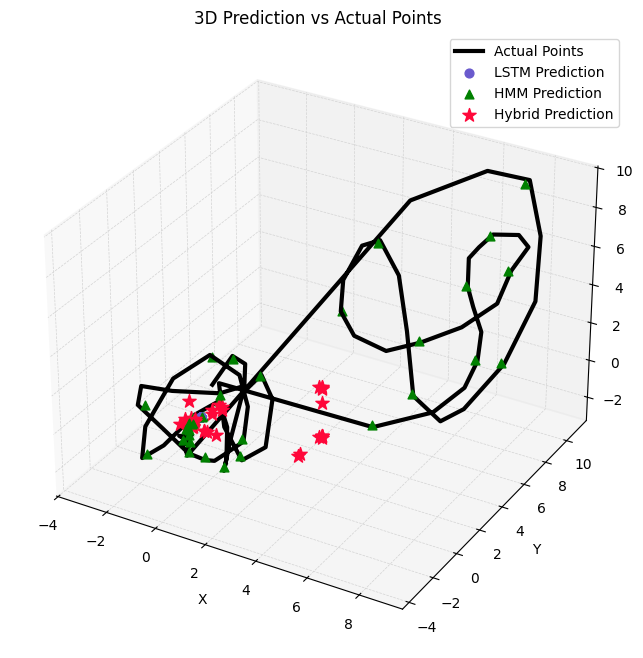


Final Error Summary:
LSTM Average 3D Error: 4.8718, Maximum 3D Error: 16.4272
HMM Average 3D Error: 1.4700, Maximum 3D Error: 14.3219
Hybrid Model Average 3D Error: 3.6045, Maximum 3D Error: 13.1356


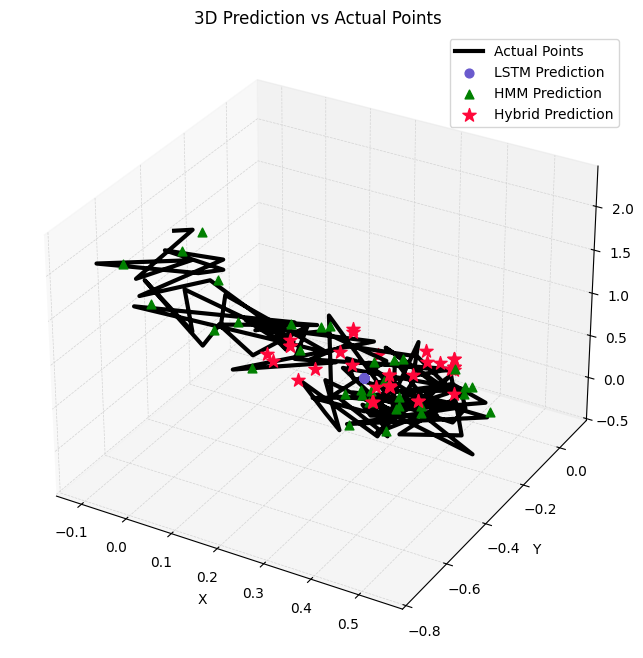


Final Error Summary:
LSTM Average 3D Error: 0.9782, Maximum 3D Error: 2.4877
HMM Average 3D Error: 0.2123, Maximum 3D Error: 0.4477
Hybrid Model Average 3D Error: 0.6142, Maximum 3D Error: 1.7334


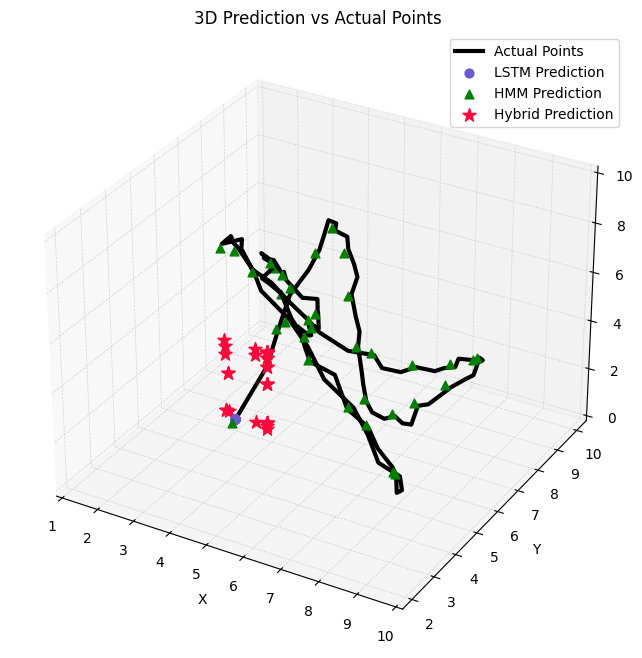


Final Error Summary:
LSTM Average 3D Error: 5.4965, Maximum 3D Error: 8.5056
HMM Average 3D Error: 0.6982, Maximum 3D Error: 1.9306
Hybrid Model Average 3D Error: 4.2701, Maximum 3D Error: 7.5174


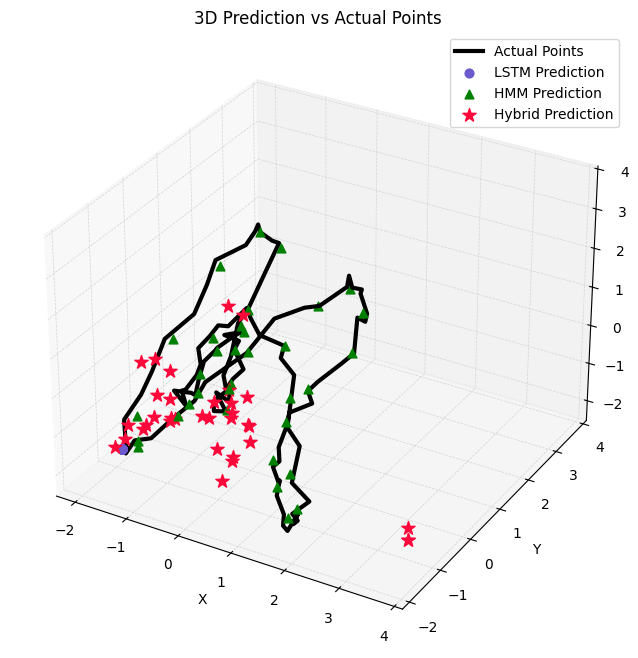


Final Error Summary:
LSTM Average 3D Error: 3.2313, Maximum 3D Error: 6.0678
HMM Average 3D Error: 0.4565, Maximum 3D Error: 0.9490
Hybrid Model Average 3D Error: 1.5789, Maximum 3D Error: 4.2595


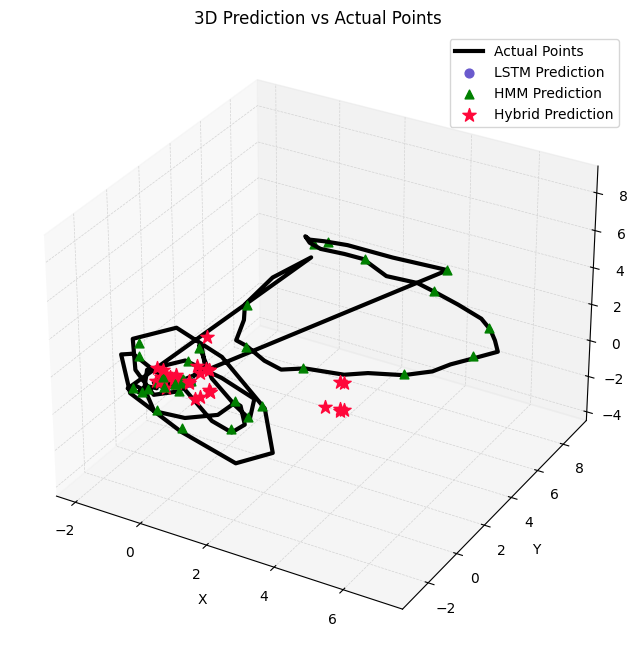


Final Error Summary:
LSTM Average 3D Error: 3.4098, Maximum 3D Error: 9.2858
HMM Average 3D Error: 1.0641, Maximum 3D Error: 10.1391
Hybrid Model Average 3D Error: 2.6095, Maximum 3D Error: 9.3606


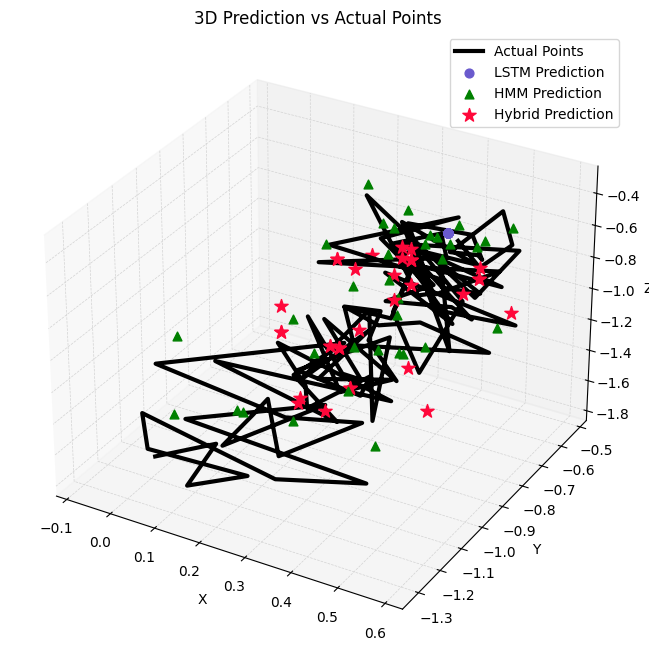


Final Error Summary:
LSTM Average 3D Error: 0.5668, Maximum 3D Error: 1.4020
HMM Average 3D Error: 0.2525, Maximum 3D Error: 0.5574
Hybrid Model Average 3D Error: 0.3026, Maximum 3D Error: 0.7358


KeyboardInterrupt: 

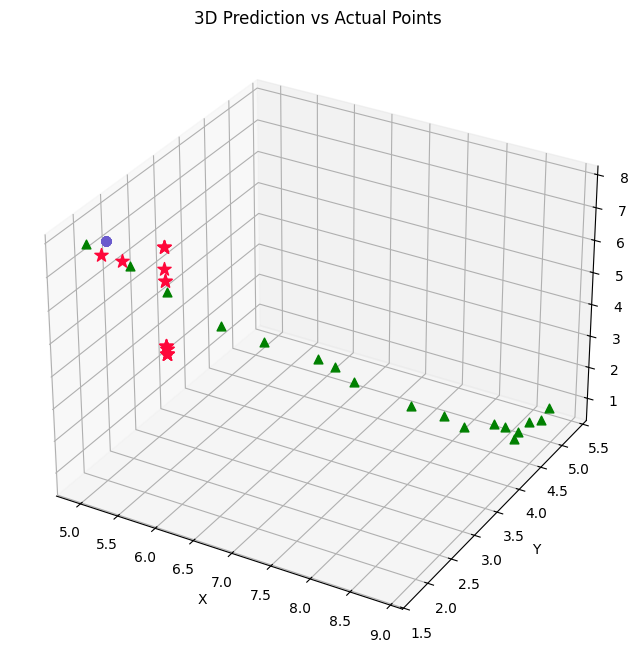

In [57]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate 3D Euclidean distance error
def calculate_3d_error(predictions, true_values):
    return np.linalg.norm(predictions - true_values, axis=1)

ped = raw_data.ped.unique()
for p in ped:
  traj1 = raw_data[raw_data.ped == p].to_numpy()[:, 2:5]
  start = np.array(traj1[0])
  rest = traj1[0:]
  his = [start]

  # Error tracking lists
  avg_lstm_error = []
  avg_hmm_error = []
  avg_hybrid_error = []

  max_lstm_error = 0
  max_hmm_error = 0
  max_hybrid_error = 0

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  count = 0


  for point in rest:
      # Convert history to tensors
      his_tensor = torch.tensor(his, dtype=torch.float32)
      his_tensor_lstm = torch.tensor([his], dtype=torch.float32)

      # Get predictions from each model
      pred_lstm = lstm(his_tensor_lstm).detach().numpy()[:, 0]
      pred_hmm = np.array(HMM.predict(his_tensor)).reshape(1, 3)

      # Hybrid Model Predictions
      X_stack = np.hstack([pred_lstm[:, 0].reshape(-1, 1), pred_hmm[:, 0].reshape(-1, 1)])
      Y_stack = np.hstack([pred_lstm[:, 1].reshape(-1, 1), pred_hmm[:, 1].reshape(-1, 1)])
      Z_stack = np.hstack([pred_lstm[:, 2].reshape(-1, 1), pred_hmm[:, 2].reshape(-1, 1)])

      pred_x = meta_model_x.predict([X_stack[-1]])
      pred_y = meta_model_y.predict([Y_stack[-1]])
      pred_z = meta_model_z.predict([Z_stack[-1]])

      pred_hybrid = np.column_stack((pred_x, pred_y, pred_z))

      # Calculate 3D error
      lstm_error = calculate_3d_error(pred_lstm, point)
      hmm_error = calculate_3d_error(pred_hmm, point)
      hybrid_error = calculate_3d_error(pred_hybrid[0], np.array([point]))

      # Store errors
      avg_lstm_error.append(lstm_error[0])
      avg_hmm_error.append(hmm_error[0])
      avg_hybrid_error.append(hybrid_error[0])

      # Update maximum errors
      max_lstm_error = max(max_lstm_error, lstm_error[0])
      max_hmm_error = max(max_hmm_error, hmm_error[0])
      max_hybrid_error = max(max_hybrid_error, hybrid_error[0])

      his.append(point)

      # 3D Scatter Plot

      colors = sns.color_palette("husl")
      if(count % 3 == 0):
        ax.scatter(pred_lstm[:, 0], pred_lstm[:, 1], pred_lstm[:, 2],
              color='slateblue', alpha=1, marker="o", s=40)

        ax.scatter(pred_hmm[:, 0], pred_hmm[:, 1], pred_hmm[:, 2],
                  color='green', alpha=1, marker='^', s=40)

        ax.scatter(pred_hybrid[:, 0], pred_hybrid[:, 1], pred_hybrid[:, 2],
              color='#ff073a', alpha=1.0, marker='*', s=100, zorder=5)
      count += 1

      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_zlabel('Z')
      ax.set_title('3D Prediction vs Actual Points')

  # continued plotting
  his = np.array(his)
  ax.plot(his[:, 0], his[:, 1], his[:, 2], color='black', alpha=1, linewidth = 3, label="Actual Points", zorder=4)

  ax.xaxis._axinfo["grid"].update(color="lightgray", linestyle="dashed", linewidth=0.5)
  ax.yaxis._axinfo["grid"].update(color="lightgray", linestyle="dashed", linewidth=0.5)
  ax.zaxis._axinfo["grid"].update(color="lightgray", linestyle="dashed", linewidth=0.5)

  ax.scatter([],[],[],
              color='slateblue', alpha=1, marker="o", s=40, label="LSTM Prediction", zorder=1)

  ax.scatter([],[],[],
              color='green', alpha=1, marker='^', s=40, label="HMM Prediction", zorder=2)

  ax.scatter([],[],[],
              color='#ff073a', alpha=1.0, marker='*', s=100, zorder=5, label="Hybrid Prediction")

  ax.legend()
  plt.show()

  # Final error reporting
  print("\nFinal Error Summary:")
  print(f"LSTM Average 3D Error: {np.mean(avg_lstm_error):.4f}, Maximum 3D Error: {max_lstm_error:.4f}")
  print(f"HMM Average 3D Error: {np.mean(avg_hmm_error):.4f}, Maximum 3D Error: {max_hmm_error:.4f}")
  print(f"Hybrid Model Average 3D Error: {np.mean(avg_hybrid_error):.4f}, Maximum 3D Error: {max_hybrid_error:.4f}")

# more plotting
# Initialize 3D Scatter Plot before the loop
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Prediction vs Actual Points')

# Initialize empty lists for storing scatter plot points
actual_points = []
lstm_points = []
hmm_points = []
hybrid_points = []

for point in rest:
    # Convert history to tensors
    his_tensor = torch.tensor(his, dtype=torch.float32)
    his_tensor_lstm = torch.tensor([his], dtype=torch.float32)

    # Get predictions
    pred_lstm = lstm(his_tensor_lstm).detach().numpy()
    pred_hmm = np.array(HMM.predict(his_tensor)).reshape(1, 3)

    # Hybrid Predictions
    X_stack = np.hstack([pred_lstm[:, 0].reshape(-1, 1), pred_hmm[:, 0].reshape(-1, 1)])
    Y_stack = np.hstack([pred_lstm[:, 1].reshape(-1, 1), pred_hmm[:, 1].reshape(-1, 1)])
    Z_stack = np.hstack([pred_lstm[:, 2].reshape(-1, 1), pred_hmm[:, 2].reshape(-1, 1)])

    pred_x = meta_model_x.predict([X_stack[-1]])
    pred_y = meta_model_y.predict([Y_stack[-1]])
    pred_z = meta_model_z.predict([Z_stack[-1]])

    pred_hybrid = np.column_stack((pred_x, pred_y, pred_z))

    # Store points
    actual_points.append(point)
    lstm_points.append(pred_lstm[0])
    hmm_points.append(pred_hmm[0])
    hybrid_points.append(pred_hybrid[0])

# Convert lists to numpy arrays for easier plotting
actual_points = np.array(actual_points)
lstm_points = np.array(lstm_points)
hmm_points = np.array(hmm_points)
hybrid_points = np.array(hybrid_points)

# Scatter all points in the same figure
ax.scatter(actual_points[:, 0], actual_points[:, 1], actual_points[:, 2], color='black', marker='o', s=50, label='Actual')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lstm_points[0, 0], lstm_points[0, 1], lstm_points[0, 2], color='red', marker='^', s=50, label='LSTM')
ax.scatter(lstm_points[1, 0], lstm_points[1, 1], lstm_points[1, 2], color='red', marker='^', s=50, label='LSTM')
ax.scatter(hmm_points[:, 0], hmm_points[:, 1], hmm_points[:, 2], color='blue', marker='s', s=50, label='HMM')
ax.scatter(hybrid_points[:, 0], hybrid_points[:, 1], hybrid_points[:, 2], color='orange', marker='*', s=50, label='Hybrid')

ax.legend()
plt.show()


Combine source approximation and hybrid model into the complete predictor

In [ ]:
# integrating the source approximation
# Constants for Gaussian plume model
Q, u, ay, by, az, bz, H = 1, 1, 0.5, 0.92, 0.5, 0.87, 1

# Euclidean distance loss function

def generate_random_points(x0, y0, z0):
    x = [0, 0, 0]
    y = [0, 0, 0]
    z = [0, 0, 0]

    for i in range(3):
        x[i] = x0 + np.random.uniform(0,1)
    for i in range(3):
        y[i] = y0 + np.random.uniform(0,1)
    for i in range(3):
        z[i] = z0 + np.random.uniform(0.01,0.1)

    return [[x[0], y[0], z[0]], [x[1], y[1], z[1]], [x[2], y[2], z[2]]]

# Function to generate synthetic data
def generate_data(sources):
    X_train, Y_train = [], []
    sources = np.array(sources)

    for x0, y0, z0 in sources:
        points = generate_random_points(x0, y0, z0)
        concentrations = []

        for x, y, z in points:

            # Constants
            x_factor = 2
            u = 1  # Wind speed
            H = 0
            ay, by = 1, 0.92
            az, bz = 1, 0.87

            # Calculate s_y and s_z
            s_y = 1 * ay * abs(x - x0) ** by
            s_z = 1 * az * abs(x - x0) ** bz

            # Take care of divide by zero by checking s_y and s_z
            if s_y == 0:
                s_y = 0.0002
            if s_z == 0:
                s_z = 0.0002

            # Calculate the exponential terms
            EXP1 = -(y - y0) ** 2 / (s_y ** 2)
            EXP2 = -(z - z0 - H) ** 2 / (2 * s_z ** 2)
            EXP3 = -(z - z0 + H) ** 2 / (2 * s_z ** 2)

            # Calculate concentration
            concentration = 100 * 1 / (2 * np.pi * s_y * s_z * u)

            # Check if x is less than x0 (if so, concentration becomes 0)
            if x < x0:
                concentration = 0

            # Calculate concentration based on the exponential terms
            concentration *= np.exp(EXP1)
            concentration *= np.exp(EXP2) + np.exp(EXP3)

            # Max concentration to 300
            if concentration > 300:
                concentration = 300


            concentrations.append(concentration)

        input_features = np.column_stack((points, concentrations))
        X_train.append(input_features)
        Y_train.append([x0, y0, z0])
    return np.array(X_train), np.array(Y_train).tolist()

# Generate and split data

# define the source model and define way to get the concentration readings
def euclidean_distance_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=1))

# Function to calculate 3D Euclidean distance error
def calculate_3d_error(predictions, true_values):
    return np.linalg.norm(predictions - true_values, axis=1)


ped = raw_data.ped.unique()
for p in ped:
  traj1 = raw_data[raw_data.ped == p].to_numpy()[:, 2:5]
  start = np.array(traj1[0])
  rest = traj1[0:]
  x, y = generate_data([start])
  his = source.predict(x).tolist()

  # Error tracking lists
  avg_lstm_error = []
  avg_hmm_error = []
  avg_hybrid_error = []

  max_lstm_error = 0
  max_hmm_error = 0
  max_hybrid_error = 0

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')


  for point in rest:
      # Convert history to tensors
      his_tensor = torch.tensor(his, dtype=torch.float32)
      his_tensor_lstm = torch.tensor([his], dtype=torch.float32)

      # Get predictions from each model
      pred_lstm = lstm(his_tensor_lstm).detach().numpy()[:, 0]
      pred_hmm = np.array(HMM.predict(his_tensor)).reshape(1, 3)

      # Hybrid Model Predictions
      X_stack = np.hstack([pred_lstm[:, 0].reshape(-1, 1), pred_hmm[:, 0].reshape(-1, 1)])
      Y_stack = np.hstack([pred_lstm[:, 1].reshape(-1, 1), pred_hmm[:, 1].reshape(-1, 1)])
      Z_stack = np.hstack([pred_lstm[:, 2].reshape(-1, 1), pred_hmm[:, 2].reshape(-1, 1)])

      pred_x = meta_model_x.predict([X_stack[-1]])
      pred_y = meta_model_y.predict([Y_stack[-1]])
      pred_z = meta_model_z.predict([Z_stack[-1]])

      pred_hybrid = np.column_stack((pred_x, pred_y, pred_z))

      # Calculate 3D error
      lstm_error = calculate_3d_error(pred_lstm, point)
      hmm_error = calculate_3d_error(pred_hmm, point)
      hybrid_error = calculate_3d_error(pred_hybrid[0], np.array([point]))

      # Store errors
      avg_lstm_error.append(lstm_error[0])
      avg_hmm_error.append(hmm_error[0])
      avg_hybrid_error.append(hybrid_error[0])

      # Update maximum errors
      max_lstm_error = max(max_lstm_error, lstm_error[0])
      max_hmm_error = max(max_hmm_error, hmm_error[0])
      max_hybrid_error = max(max_hybrid_error, hybrid_error[0])

      # 3D Scatter Plot

      # colors = sns.color_palette("husl")

      # ax.scatter(pred_hybrid[:, 0], pred_hybrid[:, 1], pred_hybrid[:, 2],
      #       color='red', alpha=1.0, marker='*', s=45, zorder=5)

      # ax.set_xlabel('X')
      # ax.set_ylabel('Y')
      # ax.set_zlabel('Z')
      # ax.set_title('3D Prediction vs Actual Points')

      x, y = generate_data([point])
      his.append(source.predict(x)[0].tolist())

  # # continued plotting
  # ax.plot(rest[:, 0], rest[:, 1], rest[:, 2], color='black', alpha=1, linewidth = 3, label="Actual Points", zorder=4)

  # ax.xaxis._axinfo["grid"].update(color="lightgray", linestyle="dashed", linewidth=0.5)
  # ax.yaxis._axinfo["grid"].update(color="lightgray", linestyle="dashed", linewidth=0.5)
  # ax.zaxis._axinfo["grid"].update(color="lightgray", linestyle="dashed", linewidth=0.5)

  # ax.scatter([],[],[],
  #               color=sns.color_palette("dark")[4], alpha=0.6, label=f'LSTM Prediction', marker='|', s=20, zorder=1)
  # ax.scatter([],[],[],
  #               color=sns.color_palette("dark")[3], alpha=0.6, label=f'HMM Prediction', marker='_', s=20, zorder=3)
  # ax.scatter([],[],[],
  #               color=sns.color_palette("bright")[8], alpha=1, label=f'Hybrid Prediction', marker='*', s=37, zorder=2)
  # ax.scatter([],[],[],
  #               color='black', label='Actual Points', marker='o', s=40, zorder=4)
  # plt.show()

  # # Final error reporting
  # print("\nFinal Error Summary:")
  # print(f"LSTM Average 3D Error: {np.mean(avg_lstm_error):.4f}, Maximum 3D Error: {max_lstm_error:.4f}")
  # print(f"HMM Average 3D Error: {np.mean(avg_hmm_error):.4f}, Maximum 3D Error: {max_hmm_error:.4f}")
  # print(f"Hybrid Model Average 3D Error: {np.mean(avg_hybrid_error):.4f}, Maximum 3D Error: {max_hybrid_error:.4f}")
